In [10]:
import numpy as np
import scipy as sp
import pandas as pd
from copy import deepcopy
import os
import os.path as op
import sys
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

loc = 'workstation'
if loc == 'workstation':
    wd = 'C:/Users/sammirc/Desktop/postdoc/tuningcurves'
elif loc == 'laptop':
    wd = '/Users/sammichekroud/Desktop/postdoc/tuningcurves'
sys.path.insert(0, op.join(wd, 'analysis', 'tools'))
os.chdir(wd)
from funcs import getSubjectInfo
from TuningCurveFuncs import makeTuningCurve, getTuningCurve_FullSpace, createFeatureBins, visualise_FeatureBins

os.chdir(wd)
subs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
subs = np.array([         4, 5, 6, 7, 8, 9,     11, 12, 13, 14, 15, 16, 17, 18,     20, 21, 22,     24, 25, 26])
#1,2,3,10,19 all have only 1 session. 23 something wrong in the second session, completely unusable eeg data due to serious noise
nsubs = subs.size
#get bin structure for data we want to load in
weightTrials = True #whether trial contributions to mean activity for a reference bin are weighted by distance from the bin centre
# binstep 4  options for binwidth: 11, 16, 22
# binstep 15 options for binwidth: 10, 15, 22
binstep, binwidth = 4, 22

times = np.load(op.join(wd, 'data', 'tuningcurves', 'times.npy'))
ntimes = times.size
nitems = 2 #two items are presented in the array, we 'decode' both
nparams = 2 #2 params as we get a beta and tvalue for glmfit and fitparam + tvalue (param/se) for optfit

nbins, binmids, binstarts, binends = createFeatureBins(binstep = binstep, binwidth = binwidth,
                                                       feature_start = -90+binstep, feature_end = 90)
smooth_alphas = True
if smooth_alphas:
    smooth_sigma=3
else:
    smooth_sigma=None

In [12]:
#read in data
subcount = -1
print(f'loading in {subs.size} participants')
alpha   = np.zeros(shape = [nsubs, nitems, ntimes]) * np.nan
glmfit = np.zeros(shape = [nsubs, nitems, nparams, ntimes]) * np.nan
optfit = np.zeros(shape = [nsubs, nitems, nparams, ntimes]) * np.nan
for i in subs:
    subcount +=1
    #print(f'working on ppt {subcount+1}/{subs.size}')
    a = np.load(op.join(wd, 'data', 'tuningcurves', 'parameter_fits', 'twostage_alphaminmaxfit',
                    f's{i}_ParamFits_Alpha_binstep{binstep}_binwidth{binwidth}_smoothedAlpha_{smooth_alphas}{smooth_sigma}.npy'))
    bgl = np.load(op.join(wd, 'data', 'tuningcurves', 'parameter_fits', 'twostage_alphaminmaxfit',
        f's{i}_ParamFits_Beta_binstep{binstep}_binwidth{binwidth}_smoothedAlpha_{smooth_alphas}{smooth_sigma}_glmfit.npy'))
    bopt = np.load(op.join(wd, 'data', 'tuningcurves', 'parameter_fits', 'twostage_alphaminmaxfit',
        f's{i}_ParamFits_Beta_binstep{binstep}_binwidth{binwidth}_smoothedAlpha_{smooth_alphas}{smooth_sigma}_optfit.npy'))

    alpha[subcount] = np.nanmean(a, axis=1) #average across trials
    glmfit[subcount] = np.nanmean(bgl, axis=1)
    optfit[subcount] = np.nanmean(bopt, axis=1)
print('done')

loading in 20 participants
done


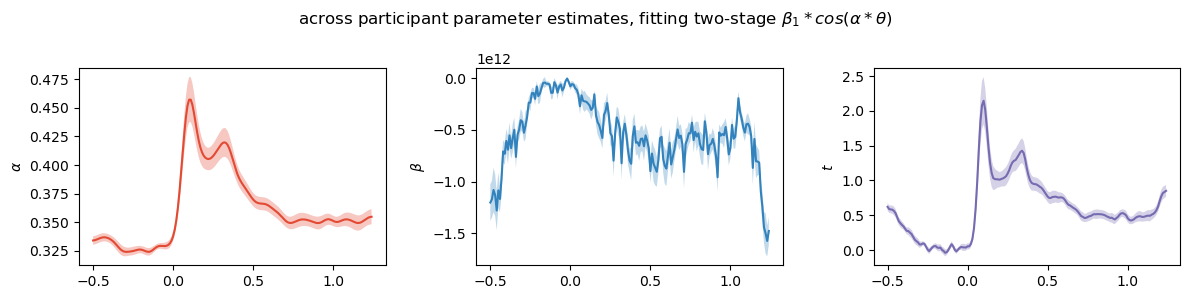

In [40]:
alpha.shape
am = np.nanmean(np.nanmean(alpha, axis=1), axis=0) #average across items then average across participants
asem = sp.stats.sem(np.nanmean(alpha, axis=1), axis=0, ddof=0, nan_policy='omit') #average across items then get sem per time point

glmb = np.nanmean(np.nanmean(glmfit, axis=1), axis=0) #average across items then across ppts
glmsem = sp.stats.sem(np.nanmean(glmfit, axis=1), axis=0, ddof=0, nan_policy='omit') #get std err per time point for both beta and t values


fig=plt.figure(figsize=[12,3])
ax=fig.add_subplot(131)
ax.plot(times, am, lw = 1.5, color = '#e34a33')
ax.fill_between(times,
                np.add(am, asem),
                np.subtract(am, asem),
                alpha=0.3, color='#e34a33', edgecolor=None)
ax.set_ylabel('$\\alpha$')
ax = fig.add_subplot(132)
ax.plot(times, glmb[0], lw = 1.5, color='#3182bd')
ax.fill_between(times, 
                np.add(glmb[0], glmsem[0]),
                np.subtract(glmb[0], glmsem[0]),
                alpha = 0.3, color = '#3182bd', edgecolor=None)
ax.set_ylabel('$\\beta$')
ax = fig.add_subplot(133)
ax.plot(times, glmb[1], lw = 1.5, color='#756bb1')
ax.fill_between(times, 
                np.add(glmb[1], glmsem[1]),
                np.subtract(glmb[1], glmsem[1]),
                alpha = 0.3, color = '#756bb1', edgecolor=None)
ax.set_ylabel('$t$')
fig.suptitle('across participant parameter estimates, fitting two-stage $\\beta_1 * cos(\\alpha * \\theta)$')
fig.tight_layout()

<font color='red'>

the above code averages across the items that are decoded in the stimulus array (decoding is done independently, and tuning curves are modelled independently). However, the items themselves should have distinct neural representations (and in some cases might be encoded differently), and averaging across decoded items in the array is not necessarily appropriate. This will be especially important when linking the magnitude (beta) or precision (alpha) of a decoded representation to behaviour, as only one of the items is reported on a given trial.

So, it's important to check whether the above timeseries are a result of some averaging process between items, and whether the decoding of the two items is markedly different, in a way that would suggest that averaging would be bad. So we can get the mean/sem for the alpha, beta and t-value timeseries and plot them over each other to visually explore differences

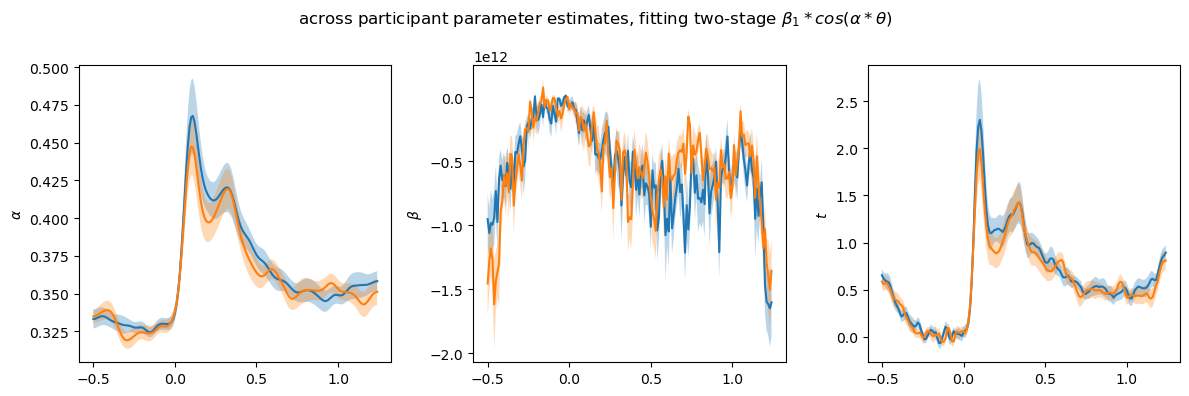

In [41]:
am = np.nanmean(alpha, axis=0) #average across items then average across participants
asem = sp.stats.sem(alpha, axis=0, ddof=0, nan_policy='omit') #average across items then get sem per time point

glmb = np.nanmean(glmfit, axis=0) #average across items then across ppts
glmsem = sp.stats.sem(glmfit, axis=0, ddof=0, nan_policy='omit') #get std err per time point for both beta and t values


fig=plt.figure(figsize=[12,4])
ax=fig.add_subplot(131)
for item in range(nitems):
    ax.plot(times, am[item], lw = 1.5)
    ax.fill_between(times,
                    np.add(am[item], asem[item]),
                    np.subtract(am[item], asem[item]),
                    alpha=0.3, edgecolor=None)
ax.set_ylabel('$\\alpha$')
ax = fig.add_subplot(132)
for item in range(nitems):
    ax.plot(times, glmb[item][0], lw = 1.5)
    ax.fill_between(times, 
                    np.add(glmb[item][0], glmsem[item][0]),
                    np.subtract(glmb[item][0], glmsem[item][0]),
                    alpha = 0.3, edgecolor=None)
ax.set_ylabel('$\\beta$')
ax = fig.add_subplot(133)
for item in range(nitems):
    ax.plot(times, glmb[item][1], lw = 1.5)
    ax.fill_between(times, 
                    np.add(glmb[item][1], glmsem[item][1]),
                    np.subtract(glmb[item][1], glmsem[item][1]),
                    alpha = 0.3, edgecolor=None)
ax.set_ylabel('$t$')
fig.suptitle('across participant parameter estimates, fitting two-stage $\\beta_1 * cos(\\alpha * \\theta)$')
fig.tight_layout()

<font color='red'>

look specifically at alpha and see how much variability there is in the single-subject timecourses

In [44]:
am.shape

(20, 175)

Text(0, 0.5, '$\\alpha$')

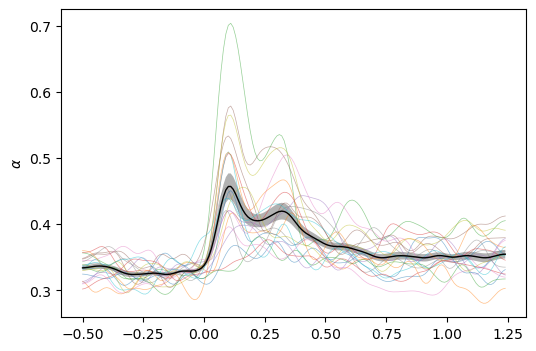

In [47]:
am = np.nanmean(alpha, axis=1) #average across items

fig=plt.figure(figsize=[6, 4])
ax=fig.add_subplot(111)
ax.plot(times, am.T, lw = 0.5, alpha=0.5)
ax.plot(times, am.mean(0), lw = 1, color='k')
ax.fill_between(times, 
                np.add(am.mean(0), sp.stats.sem(am, 0, ddof=0)),
                np.subtract(am.mean(0), sp.stats.sem(am, 0, ddof=0)),
                color='k', alpha=0.3, edgecolor=None)
ax.set_ylabel('$\\alpha$')